# Make sure we're using python 3.8+

In [306]:
import os
import sys

sys.path.append(os.path.expanduser("~/workspace/neuralflow"))

assert sys.version_info >= (3, 8, 0), "Python 3.8 or later required"

In [307]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from datagen.diffeq import gen_diffeq, vanderpol
from jax.experimental.optimizers import adam
from matplotlib.animation import FuncAnimation
from models import kernels
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm, trange


# Inline implementation of `RBFN` for modifications

In [308]:
#%%
"""
An implementation of `Interpretable Nonlinear Dynamic Modeling of Neural Trajectories`
Yuan Zhao, Il Memming Park, NIPS 2016

Equations are exact matches to those in the paper.
Generate data from a van der pol oscillator, fit with MSE, and draw vector field.
Takes ~5 ms to run per step on a 4 GHz Coffee Lake CPU.

"""

from functools import partial
from typing import Callable, Optional, Tuple, Dict

import jax.numpy as jnp
from jax import jit
from jax import value_and_grad
from jax.interpreters.xla import DeviceArray
from jax.ops import index, index_update


#%%
class RBFN:
    # When subclassing, don't forget class name in self._mse. Static method limitation.
    def __init__(self, ker: Callable, params, optimizer: Tuple[Callable, ...], window=100) -> None:
        assert {"W", "τ", "c", "σ"} <= params.keys()
        assert params["W"].shape == params["c"].shape
        assert params["W"].shape[0] == params["σ"].size
        assert jnp.all(params["τ"] > 0) and jnp.all(params["σ"] > 0)

        self.init_params, self.opt_update, self.get_params = optimizer
        self.opt_update = jit(self.opt_update)
        self.opt_state = self.init_params(params)

        self.ker = ker
        self._obj = self._mse_vgrad = jit(value_and_grad(self._mse, argnums=2, has_aux=True), static_argnums=0)
        self.t = 1
        self.window = window
        self.mask = jnp.zeros((self.window - 1, 1))  # For online training. -1 since this is multiplied with x[:-1].

    def reset(self):
        self.t = 1
        self.mask = jnp.zeros((self.window - 1, 1))
        
    @property
    def params(self):
        """Params are in in PyTree in self.opt_state for optimizer."""
        return self.get_params(self.opt_state)

    def g(self, x):
        return self._g(self.ker, x, self.params)

    def obj(self, x):
        return self._obj(self.ker, x, self.params)

    def step(self, x, loop=3, _mask=None, **kwargs):
        for _ in range(loop):
            (value, SE), grads = self._obj(self.ker, x, self.params, mask=_mask, **kwargs)
            self.opt_state = self.opt_update(self.t, grads, self.opt_state)
        self.t += 1
        return value, SE

    def step_online(self, x, loop=3, **kwargs):
        """
        Assuming the role for splitting up data for online learning for now.
        Pad for t=0...self.window.
        """
        self.mask = index_update(self.mask, self.t - 1, 1.0)
        if self.t < self.window:
            z = index_update(jnp.zeros((self.window, x.shape[1])), index[: self.t + 1, :], x[: self.t + 1, :])
        else:
            z = x[self.t : self.t + self.window]
        return self.step(z, loop, self.mask, **kwargs)

    @staticmethod
    @partial(jit, static_argnums=0)
    def _g(ker, x, p: dict):
        W, τ, c, σ = p["W"], p["τ"], p["c"], p["σ"]
        return ker(x, c, σ) @ W - jnp.exp(-(τ ** 2)) * x  # (4)

    @staticmethod
    def _mse(ker: Callable, x: DeviceArray, p: Dict[str, DeviceArray], mask: Optional[DeviceArray]):
        """||g(x_{t-1}) + x_{t-1} - x_t||²"""
        if mask is None:
            SE = jnp.square(RBFN._g(ker, x[:-1], p) + x[:-1] - x[1:])
            return jnp.mean(SE), jnp.mean(SE, axis=0)
        SE = jnp.square(RBFN._g(ker, x[:-1], p) + x[:-1] - x[1:]) * mask
        return jnp.sum(SE) / jnp.sum(mask), jnp.sum(SE, axis=0) / jnp.sum(mask, axis=0)

# %%


## Import the packages / functions

In [309]:
import matplotlib as mpl
# mpl.use("pgf")
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from tqdm.notebook import trange
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from functools import partial

from tqdm.notebook import trange

## Import the dataset (pick one!) 

#### run the cell below for the example lorenz attractor dataset 

In [242]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 20500 time points, with noise sd=0.05)
data = np.load('lorenz_1trajectories_3dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example vanderpol dataset 

In [288]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 2500 time points, with noise sd=0.05)
data = np.load('vdp_1trajectories_2dim_500to20500_noise0.2.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example jPCA dataset

In [310]:
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
ys = ys.reshape(1, -1, 6)
print(ys.shape)
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 6
ydim = ys.shape[-1]
udim = us.shape[-1]

(1, 2268, 6)


#### run the cell below for the example Neuropixel dataset

In [36]:
import scipy.io as sio
matdict = sio.loadmat('WaksmanwithFaces_KS2.mat', squeeze_me=True)
spks = matdict['stall']
spks = spks[..., None]
num_timept = spks.shape[1]

xs = None  # state
ys = spks.reshape(1, num_timept, -1)  # observation
ys = ys[:, :500, :]
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 10 # hidden state dimension
ydim = ys.shape[-1]
udim = us.shape[-1]

#### Check your data dimension

In [311]:
ys.shape

(1, 2268, 6)

## Model hyperparameters

These are the defaults from the `neuralflow` codebase, NOT sure about what the original authors used. Updating these will impact logprobs

In [312]:
window = 100              # the range the RBFN model sees in each update
updates_per_input = 3     # number of Adam updates for each window
kernel = kernels.rbf      # chosen from linear, rbf, matern32, matern52
learning_rate = 2e-2      # Adam learning rate
n_rbf = 50                # number of RBF kernels
seed = 4                  # random seed

## Training the model and calculating log probs

In [313]:
def initial_parameters():
    key = jax.random.PRNGKey(seed)
    return {
        "W": (W := 0.1 * jax.random.normal(key, shape=(n_rbf, ydim))),
        "τ": (τ := np.abs(jax.random.normal(key))),
        "c": (c := jax.random.normal(key, shape=(n_rbf, ydim))),
        "σ": (σ := np.ones(n_rbf) * ydim),
    }

net = RBFN(kernel, initial_parameters(), adam(learning_rate), window=window)

In [314]:
yy = ys[0]

MSEs = []
SEs = []
SE_ewma = None

steps_per_epoch = yy.shape[0] - window
TC = 1000

logprobs = []
    
for epoch in range(1):
    net.reset()
    with trange(steps_per_epoch, desc=f"Epochs {epoch}") as loop:
        for i in loop:
            mse, SE = net.step_online(yy, loop=updates_per_input)
            if SE_ewma is None:
                SE_ewma = SE
            else:
                SE_ewma = SE_ewma + 1 / TC * (SE - SE_ewma)
                
            logprob = -0.5 * (SE / SE_ewma + np.log(2 * SE_ewma * np.pi)).sum()  # logprob of normal distribution
            logprobs.append(logprob)
        
            loop.set_postfix(mse=mse, logprob=logprob)
            MSEs.append(mse)
            SEs.append(SE)


Epochs 0:   0%|          | 0/2168 [00:00<?, ?it/s]

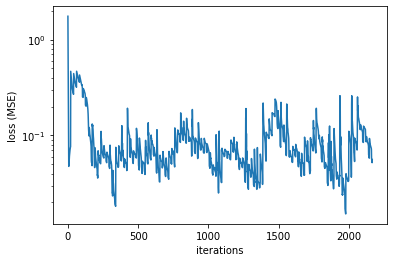

In [315]:
plt.plot(MSEs)
plt.xlabel("iterations")
plt.ylabel("loss (MSE)")
plt.yscale("log")

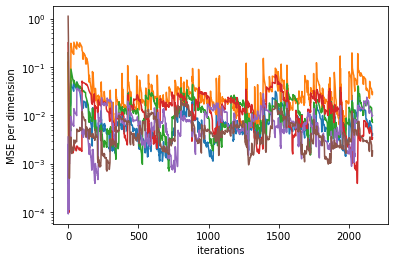

In [316]:
plt.plot(SEs)
plt.xlabel("iterations")
plt.ylabel("MSE per dimension")
plt.yscale("log")

Text(0, 0.5, 'logprobs')

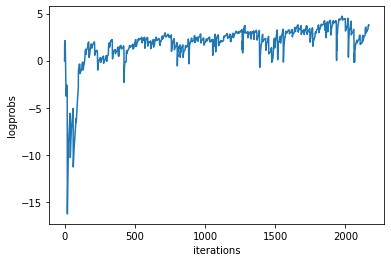

In [317]:
plt.plot(logprobs)
plt.xlabel("iterations")
plt.ylabel("logprobs")

In [318]:
np.save('logprob_zp2016_jpca.npy', np.array(logprobs))

## Plotting the log probability 

In [319]:
zp2016 = np.load('logprob_zp2016_jpca.npy')

In [320]:
vjf = np.load('logprob_jpca_6dim.npy')

In [321]:
bwrap = np.load('jpca_bubblewrap_results.npy')

(-10.0, 5.0)

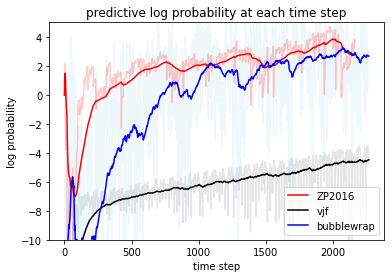

In [328]:
import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])

plt.plot(vjf, color='grey', alpha=0.2)
plt.plot(bwrap, color='lightblue', alpha=0.2)
plt.plot(zp2016, color='red', alpha=0.2)

ax = plt.gca()
ax.plot(ewma(zp2016, 100), color='red', label='ZP2016')
ax.plot(ewma(vjf, 100), color='black', label='vjf')
ax.plot(ewma(bwrap, 100), color='blue', label='bubblewrap')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('time step')
ax.set_ylabel('log probability')
ax.set_title('predictive log probability at each time step')
ax.legend()

ax.set_ylim([-10,5])

In [323]:
zp2016[1124:].mean(), zp2016[1124:].std()

(2.8717206, 0.90604484)

In [324]:
vjf[1134:].mean(), vjf[1134:].std()

(-5.159002844796153, 0.9874364416096818)

In [325]:
bwrap[1134:].mean(), bwrap[1134:].std()

(2.1898453, 2.4751472)